In [2]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np 
import matplotlib.pyplot as plt 
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
%gui qt5

# Download benchmark data

In [ ]:

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/561"
mip = 0

vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_bg.shape
print(shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/642"
mip = 0

vol_fg = CloudVolume(dir)
shape = vol_fg.shape
print(shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/axon_mask"
dir = "s3://smartspim-precomputed-volumes/2021_04_08/gad2cre_tph2flp_con_fon_8291/axon_mask"
mip = 0

vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_mask.shape
print(shape)


In [ ]:
centers_train = [[2477, 3638, 2409], [3605, 2873, 2405], [4939, 5186, 2398], [4538, 5148, 2398], [4618, 3225, 2388], [3223, 5206, 3550], [1953, 2102, 3577], [2395, 5004, 3584], [941, 3711, 708], [2030, 2164, 701], [3283, 3406, 1255], [1531, 2220, 1242], [2569, 6420, 2924], [2282, 8206, 2924], [4424, 5689, 2896], [3269, 3987, 2896], [2817, 6831, 4565], [3308, 3276, 4124], [4560, 6354, 4133], [4293, 2411, 2297], [5254, 5429, 2877], [3851, 2185, 2877], [2261, 8272, 2877], [3970, 3496, 2877], [1277, 2284, 2877]]
centers_val = [[5701, 3357, 4137], [3610, 2346, 4137], [2564, 4086, 2829], [1282, 2182, 2829], [3960, 2836, 1546], [2347, 4866, 1545], [1680, 4284, 806], [3223, 3294, 2514], [3564, 3847, 2516], [2620, 7237, 4610]]

In [ ]:
for i, center in enumerate(centers_train):
    if i < 20:
        continue
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_bg = image_bg[:,:,:,0]
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)
    

## View data

In [ ]:
center = centers_train[23]

image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_fg = image_fg[:,:,:,0]

image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_bg = image_bg[:,:,:,0]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)

## Check training results

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0

for i in range(20):
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + ".h5"
    f = h5py.File(fname, 'r')
    im = f.get('image_2channel')
    im_bg = im[0,:,:,:]
    im_fg = im[1,:,:,:]

    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + "-image_2channel_Labels.h5"
    f = h5py.File(fname, 'r')
    gt = f.get('exported_data')
    gt = gt[0,:,:,:]
    pos_labels = gt == 2
    num_pos_labels = np.sum(pos_labels)

    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + "-image_2channel_Probabilities.h5"
    f = h5py.File(fname, 'r')
    seg = f.get('exported_data')
    seg = seg[1,:,:,:]
    mask = seg > 0.5

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    true_pos_total += true_pos
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    false_pos_total += false_pos
    true_labels = np.sum(pos_labels)
    true_labels_total += true_labels
    
    if num_pos_labels > 0:
        precision = true_pos/(true_pos + false_pos)
        recall = true_pos/true_labels
        print(f"Example {i}: precision: {precision}, recall: {recall}")
    else:
        print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")

    '''
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(im_bg)
    viewer.add_image(im_fg)
    viewer.add_labels(gt)
    viewer.add_labels(mask)
    '''
print(f"Total precision: {true_pos_total/(true_pos_total + false_pos_total)} total recall: {true_pos_total/true_labels_total} with {true_labels_total} total positive voxels")

## Check Val results

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
spacing =  0.02
thresholds = np.arange(spacing, 1.0, spacing)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(10):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass
        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        '''
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Thresh: {threshold:.2f} --- Total prec.: {precision_total:.3f} total rec.: {recall_total:.3f} w/{true_labels_total} total pos voxels. F-score: {fscore:.4f}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)
plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore:.4f}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Validation Performance Brain1')
plt.legend()

## Brain 2 

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_06_02_Sert_Cre/Ch_647"
mip = 0

vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_fg.shape
print(shape)

centers_val = [[2626,3837,2366],[799,3315,2366],[3851,5443,2346],[3260,5490,2351],[3198,7658,2351],[2998,4502,1215],[4269,1657,1215],[3071,1153,3412],[3672,1792,409],[2235,4195,409]]

In [ ]:
# download data
for i, center in enumerate(centers_val):
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)
    

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
thresholds = np.arange(0.1,1.0,0.02)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(10):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass

        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        napari.run()
        '''
        
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Threshold: {threshold} ----- Total precision: {precision_total} total recall: {recall_total} with {true_labels_total} total positive voxels. F-score: {fscore}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)


plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Validation Performance Brain 2')
plt.legend()

## Check whole brain results

In [ ]:
#download from cloud
centers = [[2304, 3840, 2100], [2560, 3840, 1800]]

for i,center in enumerate(centers):
    image_fg = vol_fg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_bg = image_bg[:,:,:,0]

    mask_s3 = vol_mask[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    mask_s3 = mask_s3[:,:,:,0]

    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/test_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

    

In [ ]:
#read ilastik output
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/test_1_Probabilities.h5"
f = h5py.File(fname, 'r')
im = f.get('exported_data')
pred = im[1,:,:,:]
mask = pred > 0.32

In [ ]:
#read cis file
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_1800.h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
image_fg_cis = im[1,:,:,:,0]
image_bg_cis = im[0,:,:,:,0]

#read cis file
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_1800_Probabilities.h5"
f = h5py.File(fname, 'r')
ks = list(f.keys())
pred = f[ks[0]]
pred_cis = pred[1,:,:,:]
pred_cis = np.squeeze(pred_cis)
mask_cis = pred_cis > 0.32

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)
viewer.add_labels(mask_s3)
viewer.add_labels(mask)
viewer.add_image(image_fg_cis)
viewer.add_image(image_bg_cis)
viewer.add_labels(mask_cis)
napari.run()

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0.h5"

subprocess.run(["/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release/run_ilastik.sh",  "--headless", "--project=/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/matt_benchmark_formal.ilp", fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Brain 3

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/Ch_647"
mip = 0
vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/Ch_561"
vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/Ch_488"
vol_endo = CloudVolume(dir, parallel=1, mip=0, fill_missing=True)
print(vol_endo.shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/axon_mask"
vol_mask = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/atlas_to_target"
vol_reg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

centers_train = [[3007, 4546, 2697], [4466, 4467, 2697], [2670, 606, 2700], [1135, 751, 2700], [2354, 793, 1686], [327, 3241, 1686], [3961, 5206, 1686], [2852, 5223, 1686], [3574, 5145, 3261], [3566, 1245, 1399],
                [836, 2652, 1399], [2232, 6470, 1399], [2274, 3788, 2248], [2286, 1678, 2248], [4215, 1992, 2248], [2974, 2556, 2711], [2133, 2004, 2711], [3942, 5743, 2711], [2600, 5259, 485], [3090, 3676, 485],
                [1341, 5648, 2227], [1013, 4294, 2227], [3341, 3992, 2227], [1772, 5628, 3011], [1039, 5685, 1038], [2170, 3928, 1861], [3040, 3047, 1861]]
centers_val = [[2639, 513, 2432], [4592, 4209, 2432], [4234, 4105, 3331], [2067, 4007, 1683], [4764, 2569, 1683], [2579, 2759, 583], [3244, 3921, 575], [2298, 1555, 575], [3081, 4587, 2971], [3402, 6232, 2697],
                [4426, 4334, 1038], [857, 2867, 1038], [1665, 5523, 2391], [2027, 4258, 1861]]

## Download 3 channel data

In [ ]:
brain = 4

# download data
for i, center in enumerate(centers_val):
    if i < 0:
        continue
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_bg = image_bg[:,:,:,0]

    image_endo = vol_endo[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_endo = image_endo[:,:,:,0]

    image_3channel = np.stack([image_bg, image_fg, image_endo], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_3channel", data=image_2channel)

## View 3 channel data

In [ ]:
#view volumes
brain = 4
i = 0
set = "val"

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/" + set + "_" + str(i) + ".h5"
with h5py.File(fname, 'r') as f:
    ks = list(f.keys())
    im = f[ks[0]]
    image_bg = im[0,:,:,:]
    image_fg = im[1,:,:,:]
    image_endo = im[2,:,:,:]
    print(im.shape)

viewer = napari.Viewer(ndisplay=3)
animation_widget = AnimationWidget(viewer)
viewer.window.add_dock_widget(animation_widget, area='right')
viewer.add_image(image_bg)
viewer.add_image(image_endo)
viewer.add_image(image_fg)
napari.run()  

In [ ]:

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0.h5"
with h5py.File(fname, 'r') as f:
    ks = list(f.keys())
    im = f[ks[0]]
    image_bg = im[0,:,:,:,0]
    image_fg = im[1,:,:,:,0]
    image_endo = im[2,:,:,:,0]
    print(im.shape)

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0_Probabilities.h5"
with h5py.File(fname, 'r') as f:
    ks = list(f.keys())
    im = f[ks[0]]
    probs = im[1,:,:,:,0]
    print(im.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_bg)
viewer.add_image(image_endo)
viewer.add_image(image_fg)
viewer.add_image(probs)
napari.run()  

## Compute precision recall

In [ ]:
brain = 4

true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
thresholds = np.arange(0.1,1.0,0.02)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(7):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass

        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        napari.run()
        '''
        
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Threshold: {threshold} ----- Total precision: {precision_total} total recall: {recall_total} with {true_labels_total} total positive voxels. F-score: {fscore}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)


plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title(f'Validation Performance Brain ' + str(brain))
plt.legend()

## Downsample

In [ ]:
#downsample axon mask layer with igneous (this is only partial code, see igneous github for other code snippets)

layer_path = "s3://smartspim-precomputed-volumes/2021_07_15_Sert_Cre_R/axon_mask"

tasks = tc.create_downsampling_tasks(
    layer_path, # e.g. 'gs://bucket/dataset/layer'
    mip=0, # Start downsampling from this mip level (writes to next level up)
    fill_missing=True, # Ignore missing chunks and fill them with black
    axis='z', 
    num_mips=5, # number of downsamples to produce. Downloaded shape is chunk_size * 2^num_mip
    chunk_size=None, # manually set chunk size of next scales, overrides preserve_chunk_size
    preserve_chunk_size=True, # use existing chunk size, don't halve to get more downsamples
    sparse=False, # for sparse segmentation, allow inflation of pixels against background
    bounds=None, # mip 0 bounding box to downsample 
    encoding=None, # e.g. 'raw', 'compressed_segmentation', etc
    delete_black_uploads=False, # issue a delete instead of uploading files containing all background
    background_color=0, # Designates the background color
    compress='gzip', # None, 'gzip', and 'br' (brotli) are options
    factor=(2,2,2), # common options are (2,2,1) and (2,2,2)
  )


In [ ]:
#download higher mip

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/axon_mask"
vol_mask_ds = CloudVolume(dir, parallel=1, mip=1, fill_missing=False)
print(vol_mask_ds.shape)

data = vol_mask_ds[:,:,0,0]
data = data.astype('int8')
print(data.nbytes)
# print(np.unique(data))
data = data[:,:,:,0]
data = np.swapaxes(data, 0,2) #must do this
print(data.shape)

io.imsave("/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/axon_mask_.tif", data)


## Registration

In [ ]:
#downsample
im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/registered_2.img"
im = io.imread(im_path)
print(im.shape)
print(np.unique(im))

im = im.astype('float')

im_ds = ndi.zoom(im, (0.4,0.4,0.4))
print(im_ds.shape)
print(np.unique(im_ds))

np.save("/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/registered_3_ds.npy", im_ds)

In [ ]:
im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/axon_mask_1_0.tif"
im = io.imread(im_path)
print(im.shape)
print(np.sum(im))

In [2]:
brain = "brain3"

# im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/registered_3_ds.npy"
# im = np.load(im_path)
# print(im.shape)

# im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/axon_mask_3.tif"
# im_unreg = io.imread(im_path)
# print(im_unreg.shape)


im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/" + brain + "/register/registered_1.img"
im_reg2 = io.imread(im_path)
print(im_reg2.shape)

# im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/" + brain + "/register/registered_3.img"
# im_reg3 = io.imread(im_path)
# print(im_reg3.shape)

# vol = CloudVolume(
#     "s3://open-neurodata/ara_2016/sagittal_10um/annotation_10um_2017", mip=0, use_https=True
# )
# print(vol.shape)
# atlas = vol[:,:,:,:]
# atlas = np.squeeze(atlas).T
# print(atlas.shape)
# len(np.unique(atlas))

im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/ara_10um.tif"
atlas = io.imread(im_path)
print(atlas.shape)

NiftiImageIO (0x7fedc55233a0): /Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/registered_1.img is Analyze file and it's deprecated 

NiftiImageIO (0x7fedc55233a0): /Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/registered_1.img is Analyze file and it's deprecated 



(1140, 800, 1320)
5395603739
(1140, 800, 1320)


In [3]:
smooth = ndi.gaussian_filter(im_reg2.astype('float'), sigma=3)
#smooth = ndi.zoom(smooth, (0.4,0.4,0.4))

In [5]:
viewer = napari.Viewer(ndisplay=3)
animation_widget = AnimationWidget(viewer)
viewer.window.add_dock_widget(animation_widget, area='right')
#viewer.add_image(im)
viewer.add_image(smooth)
#viewer.add_image(im_reg2)
#viewer.add_image(im_reg3)
viewer.add_labels(atlas)
napari.run() 

[0.00000000e+00 7.99058169e-13 1.68690058e-12 ... 7.04095064e+01
 7.05842715e+01 7.06861963e+01]
[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00000000e+00 7.99058169e-13 1.68690058e-12 ... 7.13040641e+01
 7.13115579e+01 7.13415093e+01]
[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00000000e+00 7.99058169e-13 1.68690058e-12 ... 1.16927411e+02
 1.17153774e+02 1.18257114e+02]
[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00000000e+00 7.99058169e-13 1.68690058e-12 ... 1.11676010e+02
 1.12086011e+02 1.12472072e+02]
[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00000000e+00 7.99058169e-13 1.68690058e-12 ... 7.44036185e+01
 7.45108138e+01 7.46093741e+01]
[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


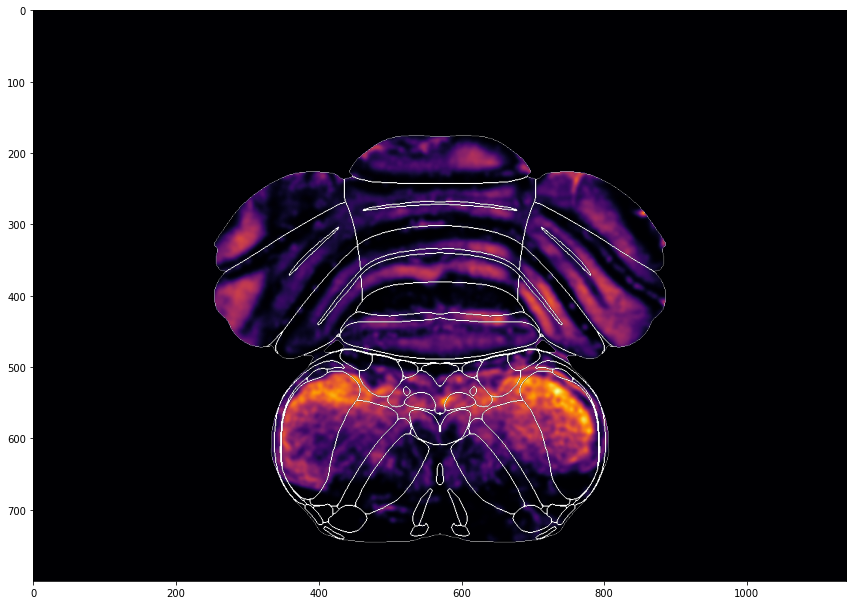

In [4]:
for z in [180, 430, 680, 1030, 1280]:

    slice = atlas[:,:,z]
    slice_data = smooth[:,:,z]#np.sum(im_reg[:,:,z], axis=2)
    mn = np.amin(slice_data)
    print(np.unique(slice_data))
    slice_data[slice == 0] = mn
    labels = measure.label(slice)
    #plt.imshow(labels)

    borders = 0*labels
    for label in np.unique(labels):
        if label != 0:
            mask = np.array(labels == label, dtype='int')
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    print(np.unique(borders))
    borders = borders.astype('float')
    borders_layer = np.zeros((borders.shape[0],borders.shape[1],4))
    for rgba in range(borders_layer.shape[2]):
        borders_layer[:,:,rgba] = borders


    slice_data = ndi.rotate(slice_data, 270)
    plt.imshow(slice_data, cmap='inferno')
    borders_layer = ndi.rotate(borders_layer, 270)
    plt.imshow(borders_layer, cmap='gray')

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('/Users/thomasathey/Desktop/' + str(z) + '.png', dpi=100)

## Atlas readout

In [ ]:
volumes = {}
for x in tqdm(np.arange(0, vol_mask.shape[0], 128)):
    x2 = np.amin([x+128, vol_mask.shape[0]])
    for y in tqdm(np.arange(0, vol_mask.shape[1], 128), leave=False):
        y2 = np.amin([x+128, vol_mask.shape[1]])
        for z in tqdm(np.arange(0, vol_mask.shape[2], 128), leave=False):
            z2 = np.amin([x+128, vol_mask.shape[2]])
            labels = vol_reg[x:x2,y:y2,z:z2]
            labels_unique = np.unique(labels)
            mask = vol_mask[x:x2,y:y2,z:z2]

            for unq in labels_unique:
                if unq in volumes.keys():
                    cur_vol = volumes[unq][1]
                    cur_total = volumes[unq][0]
                else:
                    cur_vol = 0
                    cur_total = 0
                cur_vol += np.sum(mask[labels == unq])
                cur_total += np.sum(labels == unq)
                volumes[unq] = [cur_total, cur_vol]

## Read quantification dictionary

In [11]:
path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain3/quantification.pkl"
with open(path, "rb") as f:
   quantification_dict_3 = pickle.load(f)

In [12]:
quantification_dicts = {"3": quantification_dict_3}

In [24]:
regions = [688, 698, 1089, 583, 477, 803, 703, 1097, 549, 313, 1065]

In [15]:
f = json.load(open('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json','r'))

tree = build_tree(f)
stack = [tree]

In [21]:
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(node.id, level = node.level, st_level = node.st_level, name = node.name, acronym = node.acronym, label = str(node.st_level) + ") " +node.name)
    for brain in quantification_dicts.keys():
        G.nodes[node.id][brain + " axon"] = 0
        G.nodes[node.id][brain + " total"] = 0
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

i_test = 0
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])
for brain,quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain + " axon"] = G.nodes[key][brain + " axon"] + quantification_dict[key][0]
            G.nodes[key][brain + " total"] = G.nodes[key][brain + " total"] + quantification_dict[key][1]
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]['level'] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain + " axon"] = G.nodes[parent][brain + " axon"] + G.nodes[node][brain + " axon"]
                G.nodes[parent][brain + " total"] = G.nodes[parent][brain + " total"] + G.nodes[node][brain + " total"]
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

Max level: 10
0
0
655559.0
45073920
264187568.0
6058757376


## pandas + seaborn

In [ ]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [33]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain + " axon"]
    totals[brain] = total

axon_vols = []
axon_denss = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        for brain in quantification_dicts.keys():
            axon_vols.append(G.nodes[child][brain + " axon"]/totals[brain]*100)
            if G.nodes[child][brain + " total"] == 0 and G.nodes[child][brain + " axon"] == 0:
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(G.nodes[child][brain + " axon"]/G.nodes[child][brain + " total"]*100)

            if brain in ["3", "4"]:
                gene.append("sert cre")
            else:
                gene.append("gad2")
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])

d = {"Percent Axon Volume (%)": axon_vols, "Axon Density (%)": axon_denss, "Gene": gene, "Subregion": subregion_name, "Region": region_name}
df = pd.DataFrame(data = d)


Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


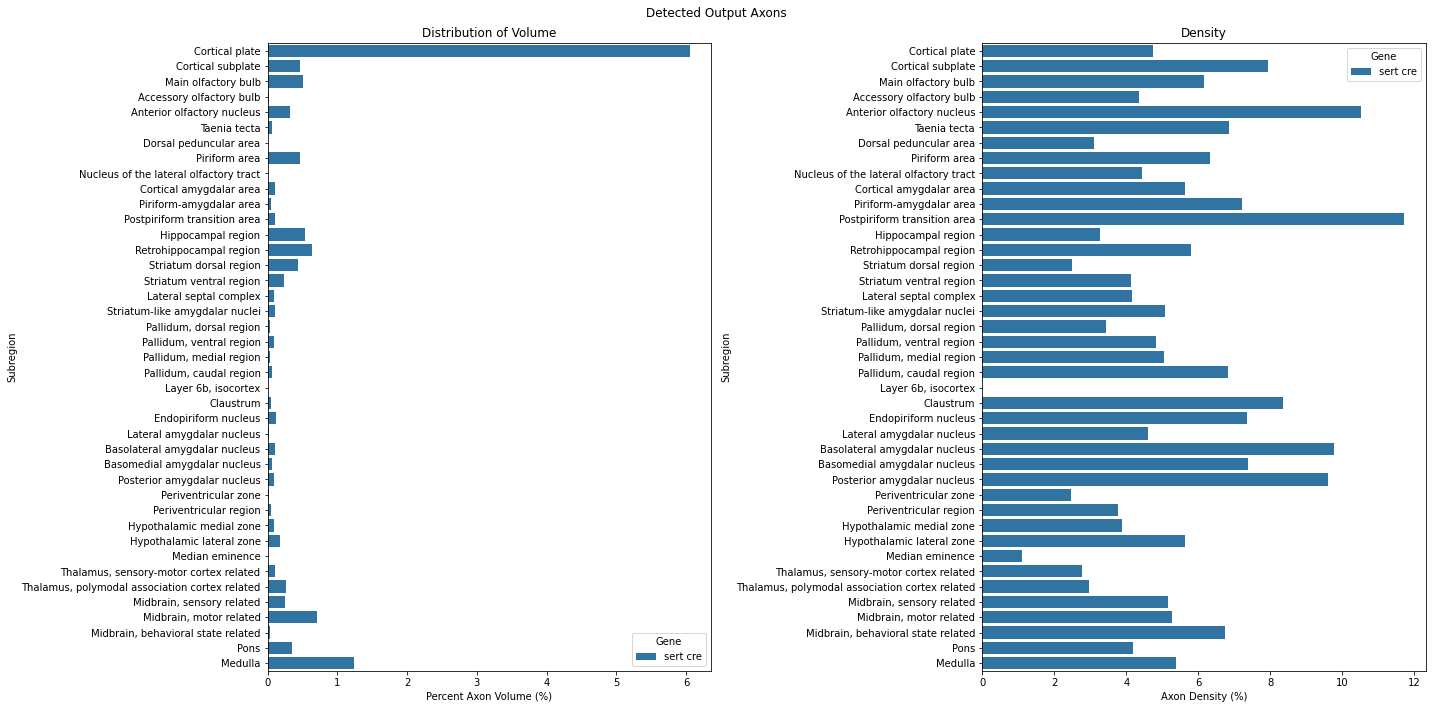

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Detected Output Axons')

sns.barplot(ax = axes[0], x = "Percent Axon Volume (%)", y = "Subregion",  hue= "Gene", data=df)
axes[0].set_title("Distribution of Volume")

sns.barplot(ax = axes[1], x = "Axon Density (%)", y = "Subregion",  hue= "Gene", data=df)
axes[1].set_title("Density")

fig.tight_layout()

# Brain 4

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/Ch_647"
mip = 0
vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/Ch_561"
vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/Ch_488"
vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
print(vol_endo.shape)


dir_mask = "s3://smartspim-precomputed-volumes/2021_07_01_Sert_Cre_B/axon_mask"
vol_mask = CloudVolume(dir_mask, parallel=1, mip=mip, fill_missing=True)
print(vol_endo.shape)

#dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/axon_mask"
#vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

#dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/atlas_to_target"
#vol_reg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

centers_train = []
centers_val = [[4781, 3581, 1861], [2982, 482, 1841], [2258, 6504, 1392], [2884, 2434, 1392], [1659, 4108, 1392], [3457, 5082, 1392], [2850, 5163, 3116]]

# Old

### Read swcs

In [ ]:
from brainlit.utils.Neuron_trace import NeuronTrace
from pathlib import Path
from scipy.ndimage import distance_transform_edt

In [ ]:
swc_path = Path("/Users/thomasathey/Documents/mimlab/mouselight/ailey/" + part + "_traces/")

swc_files = list(swc_path.glob("**/*.swc"))

paths_total = []
for swc_num, swc in enumerate(swc_files):

    swc_trace = NeuronTrace(path=str(swc))
    paths = swc_trace.get_paths()
    offset_diff, _, _, _ = swc_trace.get_df_arguments()

    for path_num, p in enumerate(paths):
        paths_total.append(p)

In [ ]:
swc_mask = 0*mask
for path in paths_total:
    path = path.astype(int)
    swc_mask[path[:,0], path[:,1], path[:,2]] = 1
    
edt = distance_transform_edt(swc_mask==0)
swc_mask[edt < 2] = 1

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.swapaxes(image,0,2))
viewer.add_labels(np.swapaxes(mask,0,2))
#viewer.add_labels(swc_mask)
#viewer.add_shapes(data=paths_total, shape_type='path', edge_width=1.0, edge_color='blue', opacity=0.8)

In [ ]:
tpr = np.sum(np.logical_and(swc_mask, np.swapaxes(mask,0,2)))/np.sum(swc_mask)
fpr = np.sum(np.logical_and(swc_mask==0, np.swapaxes(mask==1,0,2)))/np.sum(swc_mask==0)
print(f"TPR: {tpr}, FPR: {fpr}")

# Make annotation layer

Making new annotation layer
-output data and x,y,z bounds

In [3]:
vol_bg = CloudVolume("s3://smartspim-precomputed-volumes/2022_01_14/8613/Ch_647")
print(vol_bg.resolution)
print(vol_bg.voxel_offset)

[1830 1830 2000]
[0 0 0]


cannot write to https link, can write to s3 link

In [4]:

dir = "s3://smartspim-precomputed-volumes/2022_01_14/8613/axon_mask"

info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    encoding        = 'raw', # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution      = vol_bg.resolution, # Voxel scaling, units are in nanometers
    voxel_offset    = vol_bg.voxel_offset, # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 128, 128, 2 ], # units are voxels
    volume_size     = vol_bg.volume_size, # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume(dir, info=info)
vol_mask.commit_info()

In [ ]:
vol_mask[1280:1408,1280:1408,1280:1408] = np.zeros([128,128,128], dtype='uint64')

In [ ]:

image_fg = vol_fg[2432:2560, 3584:3712, 2400:2440]
image_bg = vol_bg[2432:2560, 3584:3712, 2400:2440]
image_2channel = np.stack([image_bg, image_fg], axis=0)
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example.h5"
with h5py.File(fname, "w") as f:
    dset = f.create_dataset("image_2channel", data=image_2channel)

In [ ]:
example = "off_2"

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example.h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
im_fg = im[1,:,:,:,0]

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example_Probabilities_3d_2channel.h5"
f = h5py.File(fname, 'r')
pred = f.get('exported_data')
pred = pred[1,:,:,:,0]
mask = pred > 0.5
try:
    mask = removeSmallCCs(mask, 100)
except ValueError:
    mask = 0*im_fg

print(im_fg.shape == mask.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im_fg)
viewer.add_labels(mask)
napari.run()

In [ ]:
vol_mask[2432:2560, 3584:3712, 2400:2440, 0] = mask.astype('uint64')

In [ ]:
mask2 = vol_mask[2432:2560, 3584:3712, 2400:2440, 0]
mask2.shape

In [ ]:
mask.shape

https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=E-917tNc_GylnQ

## Brainlit example

In [ ]:
dir = "s3://open-neurodata/brainlit/brain2/axons"

info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    encoding        = 'raw', # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution      = vol_brainlit.resolution, # Voxel scaling, units are in nanometers
    voxel_offset    = vol_brainlit.voxel_offset, # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 68, 52, 80 ], # units are voxels
    volume_size     = vol_brainlit.volume_size, # e.g. a cubic millimeter dataset
)
vol = CloudVolume(dir, info=info)
vol.commit_info()

In [ ]:
import numpy as np 

In [ ]:
a = np.zeros((68,52,80), dtype='uint64')
a[30:35,:,:] = 1
vol[:68,:52,:80] = a

# Second sample

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_06_02_Sert_Cre/Ch_647"

vol_fg = CloudVolume(dir)

## Download and save samples

In [ ]:
pos_centers = [[3071, 765, 2342], [5065, 3455, 2342], [3262, 7854, 2342]] #tectum, cortex, olfactory bulb
neg_centers = [[3557, 4797, 2342], [1564, 1997, 2342], [1606, 5204, 2342]] #?, edge of brain/tectum, white matter
radius = 100

for i, center in enumerate(pos_centers):
    image_fg = vol_fg[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/on_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)


for i, center in enumerate(neg_centers):
    image_fg = vol_fg[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/off_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

## Read ilastik results

In [ ]:
example = "off_2"

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/" + example + ".h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
im_fg = im[1,:,:,:,0]

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/" + example + "_Probabilities_3d_2channel.h5"
f = h5py.File(fname, 'r')
pred = f.get('exported_data')
pred = pred[1,:,:,:,0]
mask = pred > 0.5

try:
    mask = removeSmallCCs(mask, 100)
except ValueError:
    mask = 0*im_fg

print(im_fg.shape == mask.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im_fg)
viewer.add_labels(mask)
napari.run()

brain 1

In [ ]:
from brainlit.utils import NeuroglancerSession

In [ ]:
vol_im1 = CloudVolume('https://open-neurodata.s3.amazonaws.com/brainlit/brain1', parallel=1, mip=0, fill_missing=True)
vol_skel1 = CloudVolume('precomputed://https://open-neurodata.s3.amazonaws.com/brainlit/brain1_segments')
skel2 = vol_skel1.skeleton.get(11)
skel2.vertices
#session = NeuroglancerSession("s3://open-neurodata/brainlit/brain1", 0)

In [ ]:
coord = skel2.vertices[0,:]
coord = np.divide(coord, vol_im1.resolution)

In [ ]:
coord = [19796.43356643, 14046.11235955,  5254.32142857]
coord = [int(c) for c in coord]
image = vol_im1[coord[0]-50:coord[0]+50, coord[1]-50:coord[1]+50, coord[2]-50:coord[2]+50]
image = np.squeeze(image)
image.shape

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image)
napari.run()